# Data Preprocessing

In [177]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [178]:
dataPath = './aideeplearningproject2022/dataset/Images'
trianPath = './aideeplearningproject2022/train.csv'
trainCsv = pd.read_csv(trianPath, sep=',')

In [179]:
train_df, vali_df = train_test_split(trainCsv,
                                     test_size=0.3, 
                                     shuffle=True, 
                                     stratify=trainCsv['classify'], 
                                     random_state=20)

In [180]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   zoom_range=[0.8, 1.1],
                                   width_shift_range=[-0.05, 0.05],
                                   height_shift_range=[-0.05, 0.05])
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    dataPath,
                                                    x_col='file',
                                                    y_col='breed',
                                                    target_size=(224, 224),
                                                    # class_mode='categorical',
                                                    batch_size=16,
                                                    shuffle=False)

vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = train_datagen.flow_from_dataframe(vali_df,
                                                   dataPath,
                                                   x_col='file',
                                                   y_col='breed',
                                                   target_size=(224, 224),
                                                #    class_mode='categorical',
                                                   batch_size=1,
                                                   shuffle=False)

Found 576 validated image filenames belonging to 16 classes.
Found 247 validated image filenames belonging to 16 classes.


In [181]:
# x_data = []
# y_data = []
# for i in range(len(trainCsv)):
#     image = load_img(os.path.join(dataPath, trainCsv.iloc[i, 0]))
#     label = trainCsv.iloc[i, 2]
#     x_data.append(img_to_array(image))
#     y_data.append([label])

# x_data = np.array(x_data)
# y_data = np.array(y_data)

In [182]:
# classes = np.sort(trainCsv["breed"].unique()).tolist()
# y_data = tf.keras.utils.to_categorical(y_data, len(classes))
# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data,
#                                                   test_size=0.3, 
#                                                   shuffle=True, 
#                                                   stratify=y_data, 
#                                                   random_state=20)


In [183]:
# trainDataGen = ImageDataGenerator(rescale=1./255.,
#                                   horizontal_flip=True,
#                                 #   height_shift_range=0.2,
#                                 #   width_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   # rotation_range=20,
#                                   validation_split=0.2)
# validationDataGen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

# trainGenerator = trainDataGen.flow_from_directory(dataPath,
#                                                   subset='training',
#                                                   batch_size=32,
#                                                   target_size=(96, 96),
#                                                   class_mode='categorical',
#                                                   shuffle=True,
#                                                   seed=10)
# validationGenerator = validationDataGen.flow_from_directory(dataPath,
#                                                             subset='validation',
#                                                             batch_size=32,
#                                                             target_size=(96, 96),
#                                                             class_mode='categorical',
#                                                             shuffle=True,
#                                                             seed=10)


# Create Model and Train

In [184]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
import absl.logging

In [185]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [186]:
pretrained_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model = models.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=16, activation='softmax')
])
    

In [187]:
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
early_stopping = callbacks.EarlyStopping(patience=10)
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      patience=3,
                                                      factor=0.5,
                                                      min_lr=0.0001,
                                                      verbose=2)
cp = callbacks.ModelCheckpoint(filepath='./vgg16_model_ckpt', save_weight_only=True, verbose=2)
callback = [early_stopping, learning_rate_reduction, cp]


In [188]:
# model.summary()

In [189]:
hist = model.fit(train_generator,
                 validation_data=vali_generator,
                 callbacks=[callback],
                 epochs=100,
                 verbose=2)

Epoch 1/100


KeyboardInterrupt: 

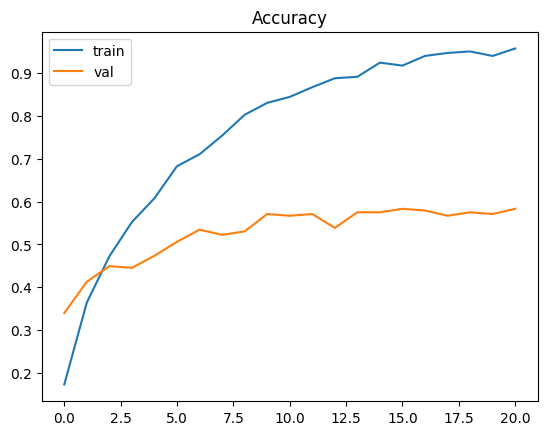

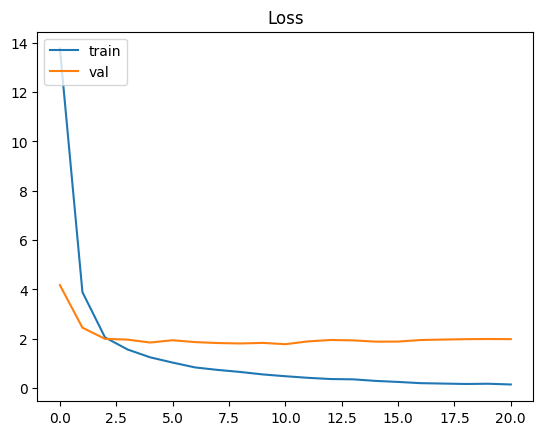

In [ ]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
model.save('catClassify_VGG16.h5')